In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Deep Learning vs Traditional ML for Anomaly Detection

## General Imports

In [1]:
# Import libraries to verify installation
import seaborn as sns
import os
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from datetime import datetime
from matplotlib.colors import Normalize
import tqdm
import PIL
import pickle
import sys
import json
from scipy.stats import skew
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from scipy.spatial.distance import euclidean
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense
from tensorflow.keras.layers import LSTM

import warnings

warnings.filterwarnings("ignore")

In [ ]:
path = "drive/MyDrive/"

In [2]:
path = ""

## Dataset

In [3]:
df = pd.read_csv(f'{path}data.csv')

In [ ]:
print(df.shape)
df.head()

(5000000, 20)


,timestamp,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1,y,category
0,2023-01-01 00:00:00,0.0,1.0,20.000000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
1,2023-01-01 00:00:01,0.0,1.0,20.080031,0.00002,0.0002,0.0,0.0,0.0,0.0,0.0,4.993912e-07,0.000789,0.0,0.0,0.0,0.000021,0.001229,0.0,0.0
2,2023-01-01 00:00:02,0.0,1.0,20.276562,0.00004,0.0004,0.0,0.0,0.0,0.0,0.0,1.496957e-06,0.003115,0.0,0.0,0.0,0.000104,0.004833,0.0,0.0
3,2023-01-01 00:00:03,0.0,1.0,20.730938,0.00006,0.0006,0.0,0.0,0.0,0.0,0.0,2.991484e-06,0.006914,0.0,0.0,0.0,0.000285,0.010688,0.0,0.0
4,2023-01-01 00:00:04,0.0,1.0,21.118101,0.00008,0.0008,0.0,0.0,0.0,0.0,0.0,4.981761e-06,0.012123,0.0,0.0,0.0,0.000601,0.018669,0.0,0.0


In [4]:
df = df.drop('timestamp', axis = 1)

## EDA and Preprocessing

In [5]:
# split the data into x and y dataframes

X_df = df.drop('y', axis=1)
X_df = X_df.drop('category', axis=1)
y_df = df['y']

In [ ]:
print(X_df.shape)
X_df.head()

(5000000, 18)


,aimp,amud,arnd,asin1,asin2,adbr,adfl,bed1,bed2,bfo1,bfo2,bso1,bso2,bso3,ced1,cfo1,cso1,category
0,0.0,1.0,20.000000,0.00000,0.0000,0.0,0.0,0.0,0.0,0.0,0.000000e+00,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
1,0.0,1.0,20.080031,0.00002,0.0002,0.0,0.0,0.0,0.0,0.0,4.993912e-07,0.000789,0.0,0.0,0.0,0.000021,0.001229,0.0
2,0.0,1.0,20.276562,0.00004,0.0004,0.0,0.0,0.0,0.0,0.0,1.496957e-06,0.003115,0.0,0.0,0.0,0.000104,0.004833,0.0
3,0.0,1.0,20.730938,0.00006,0.0006,0.0,0.0,0.0,0.0,0.0,2.991484e-06,0.006914,0.0,0.0,0.0,0.000285,0.010688,0.0
4,0.0,1.0,21.118101,0.00008,0.0008,0.0,0.0,0.0,0.0,0.0,4.981761e-06,0.012123,0.0,0.0,0.0,0.000601,0.018669,0.0


In [ ]:
print(y_df.shape)
y_df.head()

(5000000,)


0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: y, dtype: float64

This section is dedicated to the exploratory data analysis of the dataset. Upon loading the dataset, we check its basic information.

In [ ]:
# check for missing values

df.isnull().sum()

timestamp    0
aimp         0
amud         0
arnd         0
asin1        0
asin2        0
adbr         0
adfl         0
bed1         0
bed2         0
bfo1         0
bfo2         0
bso1         0
bso2         0
bso3         0
ced1         0
cfo1         0
cso1         0
y            0
category     0
dtype: int64

In [6]:
# load metadata csv

df_metadata = pd.read_csv(f'{path}metadata.csv')

In [ ]:
print(df_metadata.shape)
df_metadata.head()

(200, 5)


,start_time,end_time,root_cause,affected,category
0,2023-01-12 15:11:45,2023-01-12 15:20:05,bso3,['cfo1'],12
1,2023-01-12 16:27:46,2023-01-12 17:51:06,bso3,['cfo1'],1
2,2023-01-12 18:19:35,2023-01-12 18:36:15,bfo2,['cso1'],8
3,2023-01-12 20:46:32,2023-01-12 20:51:32,bed2,['ced1'],7
4,2023-01-13 05:57:10,2023-01-13 06:02:10,bfo1,['cfo1'],9


In [ ]:
df_metadata.category.value_counts()

category
8     28
3     22
12    20
7     20
9     18
4     15
5     13
2     13
13    12
6     12
1     11
10    10
11     6
Name: count, dtype: int64

From the metadata, we can see that we have 200 batches of injected anomalies. And, in each batch, we can see the root cause of the anomaly.

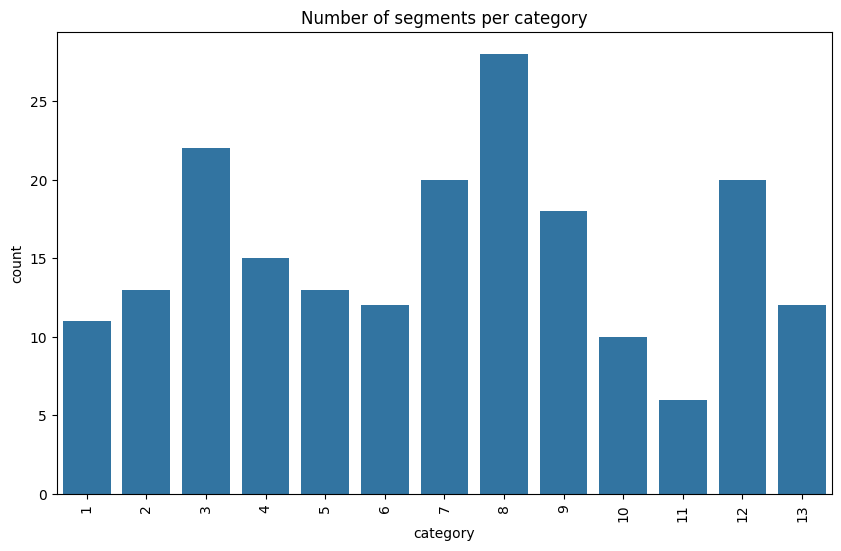

In [ ]:
# Plot graph of categories

plt.figure(figsize=(10,6))

sns.countplot(x='category', data=df_metadata)

plt.title('Number of segments per category')

plt.xticks(rotation=90)

plt.show()

No missing values!

In [ ]:
# check for class imbalance

y_df.value_counts()

y
0.0    4809900
1.0     190100
Name: count, dtype: int64

In [ ]:
# check for labels in first 1000000 rows

y_df[:1000000].value_counts()

y
0.0    1000000
Name: count, dtype: int64

In [ ]:
y_df[1000000:].value_counts()

y
0.0    3809900
1.0     190100
Name: count, dtype: int64

In [ ]:
X_df['category'].value_counts()

category
0.0     4809900
8.0       32600
1.0       20400
12.0      19600
7.0       19100
3.0       18000
4.0       15600
6.0       12100
2.0       12000
9.0       10400
5.0        9900
11.0       9100
10.0       6400
13.0       4900
Name: count, dtype: int64

This is as expected as the first 1000000 rows are the normal data and the remaining 4000000 rows contain both normal and anomalous data. Futhermore each anomaly has its own category identified, which is listed in the metadata.

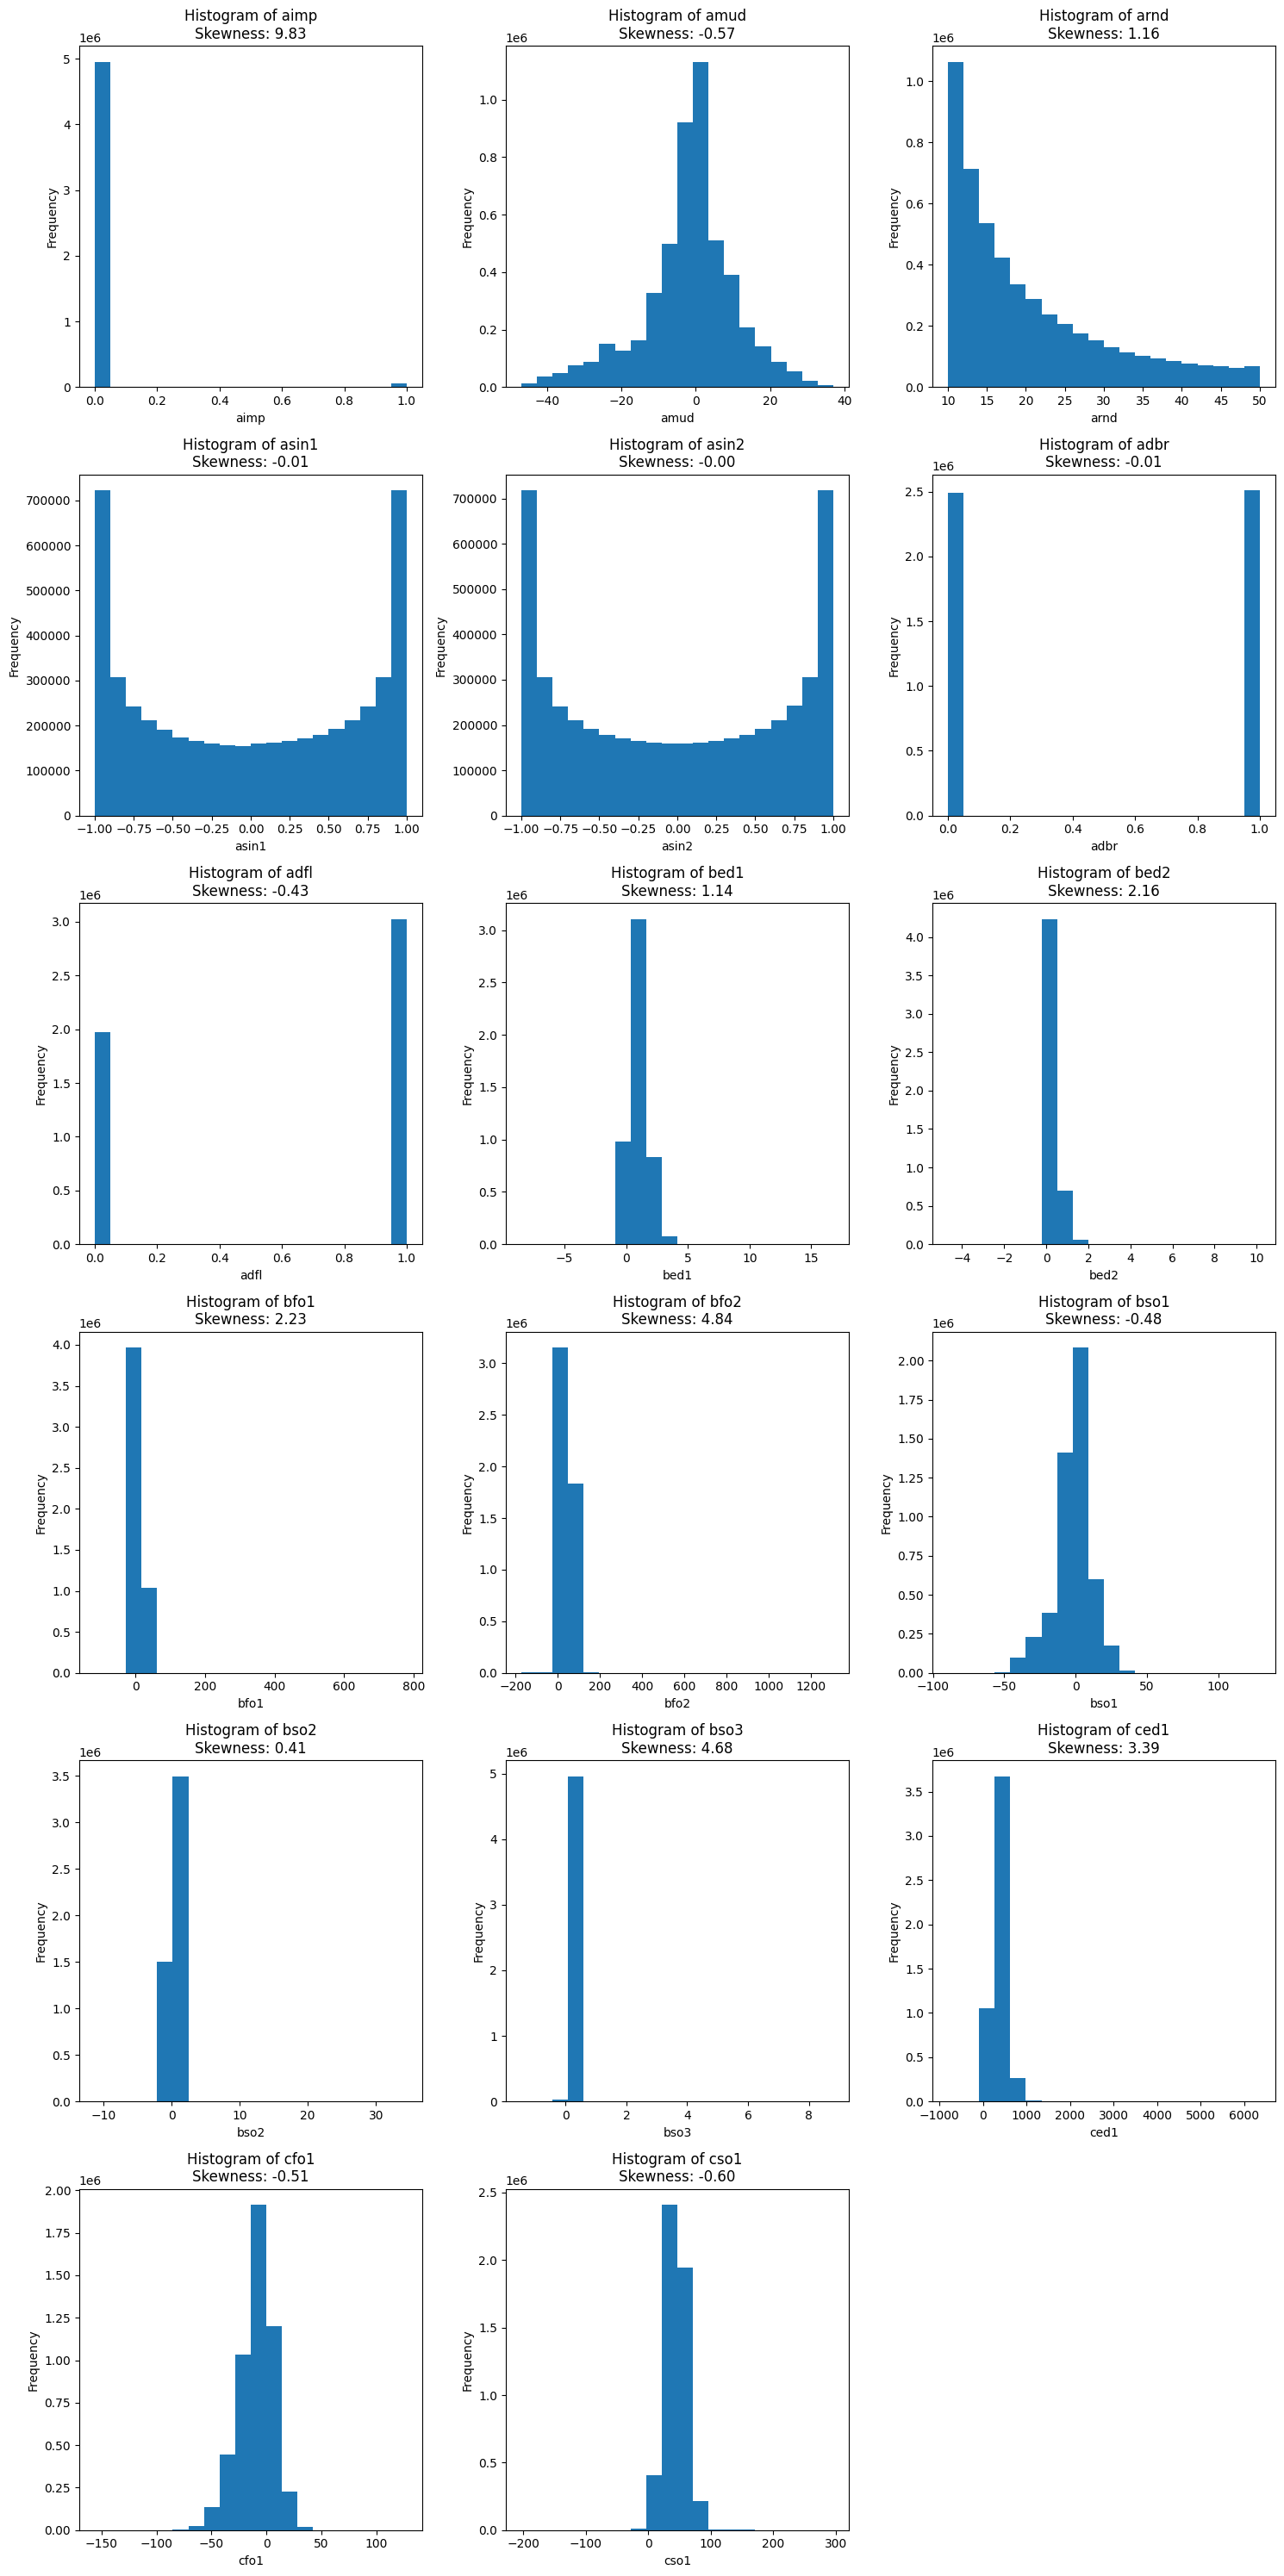

In [7]:
# Plot histograms for each numeric feature
numeric_features = X_df.select_dtypes(include=['float64', 'int64'])  # Select numeric features
numeric_columns = numeric_features.columns

num_plots = len(numeric_columns)
num_rows = int(np.ceil(num_plots/3)) # Adjust the number of rows as needed

fig, axes = plt.subplots(num_rows, 3, figsize=(15, 5*num_rows))

for i, column in enumerate(numeric_columns):
    row = i // 3
    col = i % 3
    axes[row, col].hist(X_df[column], bins=20)  # Adjust the number of bins as needed
    axes[row, col].set_xlabel(column)
    axes[row, col].set_ylabel('Frequency')
    axes[row, col].set_title(f'Histogram of {column}\nSkewness: {skew(df[column]):.2f}')

# Remove empty subplots
if num_plots % 3 != 0:
    for i in range(num_plots % 3, 3):
        fig.delaxes(axes[num_rows-1, i])

plt.tight_layout()
plt.show()


In [8]:
# check the features for which number of unique values is small

discrete_features = [feature for feature in numeric_columns if len(X_df[feature].unique()) < 100]

for feature in discrete_features:
    print(f'{feature}: {X_df[feature].unique()}')

aimp: [0. 1.]
amud: [  1.  -1.   2.   3.   6.   5.   0.  10.   7.   4.  -4.   9.  11.   8.
  16.  12.  -3.  -6.  -5. -12. -13.  -7.  -9.  -2. -10. -11.  -8. -15.
 -14. -17. -19. -21. -24. -23. -22. -25. -28. -16. -20. -30. -29. -26.
 -27. -32. -31. -34. -37. -35. -18.  13.  15.  14.  18.  21.  22.  25.
  26.  30.  27.  24.  23.  29.  28.  20.  19.  17. -33. -41. -38. -39.
 -44. -45. -36. -40. -43. -46. -42. -47.  31.  32.  33.  34.  37.  36.
  35.]
adbr: [0. 1.]
adfl: [0. 1.]


From this, we gathered that other than `category`, we have 4 features which have discrete values. Therefore, we make sure not to normalize these features (we only want to normalize the continuous features).

### Data Preprocessing

We implement K fold time series split to ensure that the model is trained on the past and tested on the future. This is important as we are dealing with time series data.

Data preprocessing steps:
- Normalizing the continuous features
- Dropping highly correlated features (if any)
- Data augmentation on training sets

In [9]:
# Define the number of splits
n_splits = 3

# Initialize TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=n_splits)

# Perform the splits
fold = 0
for train_index, test_index in tscv.split(X_df):
    fold += 1
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    print(f"Fold {fold}")
    print(f"TRAIN indices: {train_index}")
    print(f"TEST indices: {test_index}")

Fold 1
TRAIN indices: [      0       1       2 ... 1249997 1249998 1249999]
TEST indices: [1250000 1250001 1250002 ... 2499997 2499998 2499999]
Fold 2
TRAIN indices: [      0       1       2 ... 2499997 2499998 2499999]
TEST indices: [2500000 2500001 2500002 ... 3749997 3749998 3749999]
Fold 3
TRAIN indices: [      0       1       2 ... 3749997 3749998 3749999]
TEST indices: [3750000 3750001 3750002 ... 4999997 4999998 4999999]


In [10]:
# get contamination rates of train and test sets of all folds

contamination_rates = {}

for train_index, test_index in tscv.split(X_df):
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]
    train_contamination_rate = np.mean(y_train)
    test_contamination_rate = np.mean(y_test)
    contamination_rates[f"Fold {len(contamination_rates)+1}"] = {
        "Train": train_contamination_rate,
        "Test": test_contamination_rate
    }

contamination_rates

{'Fold 1': {'Train': 0.0152, 'Test': 0.04632},
 'Fold 2': {'Train': 0.03076, 'Test': 0.04344},
 'Fold 3': {'Train': 0.034986666666666666, 'Test': 0.04712}}

#### Correlation Analysis

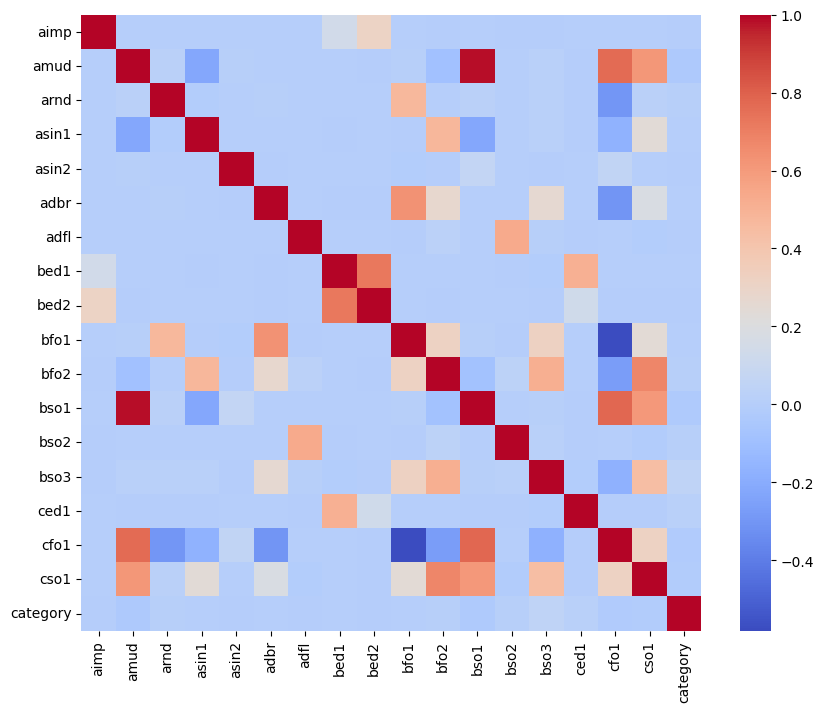

In [ ]:
# check for correlation matrix between columns, using sns heatmap

corr = X_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=False, cmap='coolwarm', linecolor='black')
plt.show()

In [11]:
def preprocess_data(X_train, X_test, y_train=None, y_test=None, correlation_threshold=0.9):
    """
    Preprocess the data by scaling features, handling missing values, and dropping highly correlated features.

    Parameters:
    X_train (DataFrame): Training feature set.
    X_test (DataFrame): Test feature set.
    y_train (Series, optional): Training labels.
    y_test (Series, optional): Test labels.
    correlation_threshold (float): Threshold for dropping highly correlated features.

    Returns:
    X_train_scaled, X_test_scaled: Scaled and preprocessed training and test feature sets.
    """

    # Drop highly correlated features in the training set, display highly correlated features
    corr_matrix_train = X_train.corr().abs()
    upper = corr_matrix_train.where(np.triu(np.ones(corr_matrix_train.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    print(f"Highly correlated features to drop for train set: {to_drop}")
    X_train_reduced = X_train.drop(columns=to_drop)

    corr_matrix_test = X_test.corr().abs()
    upper = corr_matrix_test.where(np.triu(np.ones(corr_matrix_test.shape), k=1).astype(bool))
    to_drop = [column for column in upper.columns if any(upper[column] > correlation_threshold)]
    print(f"Highly correlated features to drop for test set: {to_drop}")
    X_test_reduced = X_test.drop(columns=to_drop)

    numeric_features = X_train_reduced.select_dtypes(include=['float64', 'int64'])  # Select numeric features
    numeric_columns = numeric_features.columns
    discrete_features = [feature for feature in numeric_columns if len(X_df[feature].unique()) < 100]
    continuous_features = [feature for feature in numeric_columns if feature not in discrete_features]

    scaler = StandardScaler()
    X_train_scaled = X_train_reduced.copy()
    X_train_scaled[continuous_features] = scaler.fit_transform(X_train_reduced[continuous_features])
    X_test_scaled = X_test_reduced.copy()
    X_test_scaled[continuous_features] = scaler.transform(X_test_reduced[continuous_features])

    return X_train_scaled, X_test_scaled

Now our dataset is standardized, with highly correlated features dropped, we can proceed with data augmentation on the train set. We will use the SMOTE technique to balance the dataset.

This represents a very imbalanced dataset, with the majority class being the normal data. So, clearly, data augmentation is necessary.

In [12]:
def augment_data(X_train, y_train):
    """
    Augment the training data using SMOTE.

    Parameters:
    X_train (array-like): Training feature set.
    y_train (array-like): Training labels.

    Returns:
    X_train_resampled, y_train_resampled: Augmented training feature set and labels.
    """
    if len(np.unique(y_train)) > 1:  # Check if there is more than one class
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)
        return X_train_resampled, y_train_resampled
    else:
        # If there's only one class, return the original data
        print("SMOTE not applied, only one class present.")
        return X_train, y_train

In [13]:
# Preprocess and augment the data for each fold
X_train_scaled, X_test_scaled = {}, {}
y_train_scaled, y_test_scaled = {}, {}
X_train_augmented, y_train_augmented = {}, {}

for fold, (train_index, test_index) in enumerate(tscv.split(X_df)):
    X_train, X_test = X_df.iloc[train_index], X_df.iloc[test_index]
    y_train, y_test = y_df.iloc[train_index], y_df.iloc[test_index]

    # Preprocess the data
    X_train_scaled[fold], X_test_scaled[fold] = preprocess_data(X_train, X_test, y_train, y_test)
    y_train_scaled[fold], y_test_scaled[fold] = y_train, y_test

    print(f"Fold {fold} preprocessing complete")
    print(X_train_scaled[fold].shape)
    print(X_test_scaled[fold].shape)

    # Augment the training data
    X_train_augmented[fold], y_train_augmented[fold] = augment_data(X_train_scaled[fold], y_train_scaled[fold])

    # Print shapes of the augmented training data
    print(f"Fold {fold} augmentation complete")
    print(f"Augmented Train Data Shape: {X_train_augmented[fold].shape}")
    print(f"Augmented Train Labels Shape: {y_train_augmented[fold].shape}")
    print("\n")

Highly correlated features to drop for train set: ['bso1']
Highly correlated features to drop for test set: ['bso1']
Fold 0 preprocessing complete
(1250000, 16)
(1250000, 16)
Fold 0 augmentation complete
Augmented Train Data Shape: (2462000, 16)
Augmented Train Labels Shape: (2462000,)


Highly correlated features to drop for train set: ['bso1']
Highly correlated features to drop for test set: ['bso1']
Fold 1 preprocessing complete
(2500000, 16)
(1250000, 16)
Fold 1 augmentation complete
Augmented Train Data Shape: (4846200, 16)
Augmented Train Labels Shape: (4846200,)


Highly correlated features to drop for train set: ['bso1']
Highly correlated features to drop for test set: ['bso1']
Fold 2 preprocessing complete
(3750000, 16)
(1250000, 16)
Fold 2 augmentation complete
Augmented Train Data Shape: (7237600, 16)
Augmented Train Labels Shape: (7237600,)




In [14]:
X_train = X_train_augmented
y_train = y_train_augmented

X_test = X_test_scaled
y_test = y_test_scaled

We have now finished preparing our datasets for training.



---
# Models

## Traditional ML Models

### Unsupervised Models

#### Isolation Forests

In [57]:
from sklearn.ensemble import IsolationForest

def train_isolation_forest(X_train, contamination='auto', n_estimators=100, random_state=42):
    """
    Train an Isolation Forest model.

    Parameters:
    X_train (DataFrame): Training feature set.
    contamination (float or str): Proportion of outliers in the dataset. Default is 'auto'.
    n_estimators (int): Number of base estimators in the ensemble. Default is 100.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    IsolationForest: The trained Isolation Forest model.
    """
    # Create an Isolation Forest instance
    clf = IsolationForest(n_estimators=n_estimators, max_samples='auto', contamination=contamination, random_state=random_state, verbose = 1)

    # Fit the model on the training data
    clf.fit(X_train)

    return clf

In [63]:
# Train an Isolation Forest model for each fold

isolation_forest_models = {}

for fold in range(n_splits):
    isolation_forest_models[fold] = train_isolation_forest(X_train[fold], n_estimators = 150)
    print(f"Fold {fold} Isolation Forest model trained")

Fold 0 Isolation Forest model trained
Fold 1 Isolation Forest model trained
Fold 2 Isolation Forest model trained


In [64]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_isolation_forest(model, X_test, y_test):
    """
    Evaluate the performance of an Isolation Forest model.

    Parameters:
    model (IsolationForest): Trained Isolation Forest model.
    X_test (DataFrame): Test feature set.
    y_test (Series): True labels for the test set.

    Returns:
    dict: A dictionary containing the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    anomaly_score = model.decision_function(X_test)
    inverted_score = -anomaly_score

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, inverted_score)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    return metrics


In [65]:
# evaluate the models for each fold

isolation_forest_metrics = {}

for fold in range(n_splits):
    isolation_forest_metrics[fold] = evaluate_isolation_forest(isolation_forest_models[fold], X_test[fold], y_test[fold])
    print(f"Fold {fold} Isolation Forest model evaluated")

Fold 0 Isolation Forest model evaluated
Fold 1 Isolation Forest model evaluated
Fold 2 Isolation Forest model evaluated


In [69]:
# Display the evaluation metrics for each fold

isolation_forest_metrics_df = pd.DataFrame(isolation_forest_metrics).T

isolation_forest_metrics_df

,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.913497,0.119829,0.136718,0.127718,0.681839
1,0.872450,0.094851,0.226648,0.133735,0.621182
2,0.919862,0.213763,0.261647,0.235293,0.683119


In [70]:
# take average of evaluation metrics

isolation_forest_metrics_avg = isolation_forest_metrics_df.mean()

isolation_forest_metrics_avg

Accuracy     0.901937
Precision    0.142814
Recall       0.208338
F1 Score     0.165582
ROC AUC      0.662047
dtype: float64

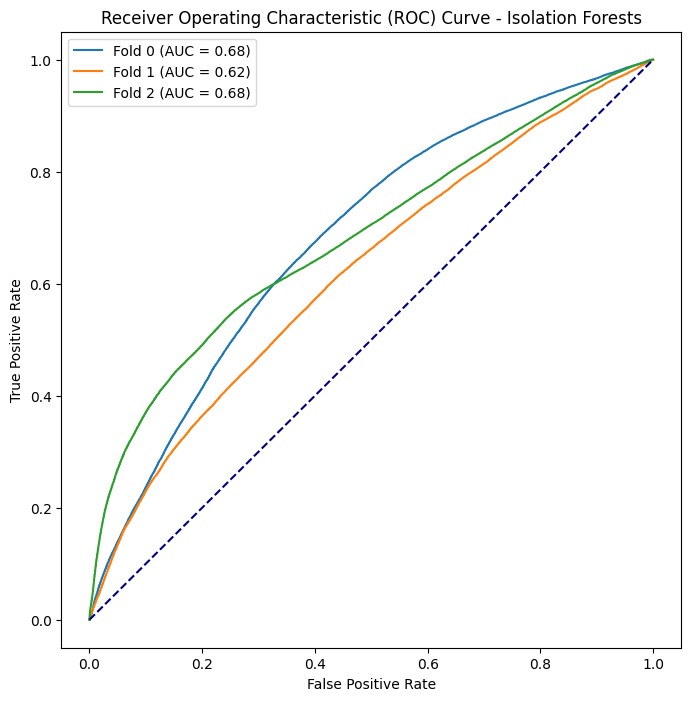

In [68]:
from sklearn.metrics import roc_curve

plt.figure(figsize=(8, 8))

for fold in range(n_splits):
    anomaly_score = isolation_forest_models[fold].decision_function(X_test[fold])
    fpr, tpr, _ = roc_curve(y_test[fold], -anomaly_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Isolation Forests')
plt.legend()
plt.show()

In [42]:
# plot confusion matrix

from sklearn.metrics import confusion_matrix, classification_report

for fold in range(n_splits):
    y_pred = isolation_forest_models[fold].predict(X_test[fold])
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1

    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test[fold], y_pred), index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion_matrix_df)
    print(classification_report(y_test[fold], y_pred))


Fold 0 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1132143              59957
Actual Anomaly             50216               7684
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95   1192100
         1.0       0.11      0.13      0.12     57900

    accuracy                           0.91   1250000
   macro avg       0.54      0.54      0.54   1250000
weighted avg       0.92      0.91      0.92   1250000

Fold 1 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1079290             116410
Actual Anomaly             41721              12579
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93   1195700
         1.0       0.10      0.23      0.14     54300

    accuracy                           0.87   1250000
   macro avg       0.53      0.57      0.53   1250000
weighted avg       0.93      0.87      

#### Gaussian Mixture Models

In [43]:
# run gaussian mixture models

from sklearn.mixture import GaussianMixture

def train_gaussian_mixture(X_train, n_components=1, covariance_type='full', random_state=42):

    """
    Train a Gaussian Mixture model.

    Parameters:
    X_train (DataFrame): Training feature set.
    n_components (int): Number of mixture components. Default is 1.
    covariance_type (str): Type of covariance parameters to use. Default is 'full'.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    GaussianMixture: The trained Gaussian Mixture model.
    """
    # Create a Gaussian Mixture instance
    gmm = GaussianMixture(n_components=n_components, covariance_type=covariance_type, random_state=random_state)

    # Fit the model on the training data
    gmm.fit(X_train)

    return gmm

In [44]:
# Train a Gaussian Mixture model for each fold

gmm_models = {}

for fold in range(n_splits):
    gmm_models[fold] = train_gaussian_mixture(X_train[fold], n_components=10)
    print(f"Fold {fold} Gaussian Mixture model trained")

Fold 0 Gaussian Mixture model trained
Fold 1 Gaussian Mixture model trained
Fold 2 Gaussian Mixture model trained


In [45]:
def evaluate_gaussian_mixtures(model, X_test, y_test):
    """
    Evaluate the performance of a Gaussian Mixture model.

    Parameters:
    model (GaussianMixture): Trained Gaussian Mixture model.
    X_test (DataFrame): Test feature set.
    y_test (Series): True labels for the test set.

    Returns:
    dict: A dictionary containing the evaluation metrics.
    """
    # Obtain log likelihoods for each sample in the test data
    log_likelihoods = model.score_samples(X_test)

    # Use the negative of log likelihoods as anomaly scores
    anomaly_scores = -log_likelihoods

    # Compute the ROC AUC score
    roc_auc = roc_auc_score(y_test, anomaly_scores)

    # Convert anomaly scores to binary labels using a default threshold (e.g., 95th percentile)
    threshold = np.percentile(anomaly_scores, 95)
    y_pred_binary = (anomaly_scores > threshold).astype(int)

    # Compute other metrics
    precision = precision_score(y_test, y_pred_binary)
    recall = recall_score(y_test, y_pred_binary)
    f1 = f1_score(y_test, y_pred_binary)
    accuracy = accuracy_score(y_test, y_pred_binary)

    metrics = {
        "ROC AUC Score": roc_auc,
        "Precision": precision,
        "Recall": recall,
        "F1 Score": f1,
        "Accuracy": accuracy
    }

    return metrics

In [46]:
# evaluate the models for each fold

gmm_metrics = {}

for fold in range(n_splits):
    gmm_metrics[fold] = evaluate_gaussian_mixtures(gmm_models[fold], X_test[fold], y_test[fold])
    print(f"Fold {fold} Gaussian Mixture model evaluated")

# Display the evaluation metrics for each fold

gmm_metrics_df = pd.DataFrame(gmm_metrics).T

gmm_metrics_df

Fold 0 Gaussian Mixture model evaluated
Fold 1 Gaussian Mixture model evaluated
Fold 2 Gaussian Mixture model evaluated


,ROC AUC Score,Precision,Recall,F1 Score,Accuracy
0,0.771611,0.354400,0.382556,0.367940,0.939120
1,0.748722,0.322592,0.371308,0.345240,0.938819
2,0.786822,0.417840,0.443379,0.430231,0.944664


In [47]:
gmm_metrics_avg = gmm_metrics_df.mean()

gmm_metrics_avg

ROC AUC Score    0.769052
Precision        0.364944
Recall           0.399081
F1 Score         0.381137
Accuracy         0.940868
dtype: float64

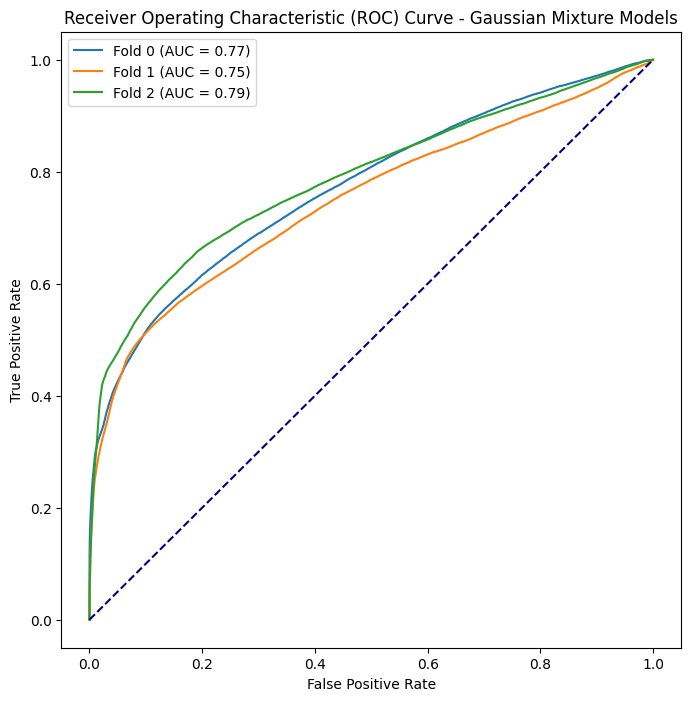

In [48]:
# plot roc curve

plt.figure(figsize=(8, 8))

for fold in range(n_splits):
    log_likelihoods = gmm_models[fold].score_samples(X_test[fold])
    anomaly_scores = -log_likelihoods
    fpr, tpr, _ = roc_curve(y_test[fold], anomaly_scores)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Gaussian Mixture Models')
plt.legend()
plt.show()

In [49]:
# plot confusion matrix

for fold in range(n_splits):
    log_likelihoods = gmm_models[fold].score_samples(X_test[fold])
    anomaly_scores = -log_likelihoods
    threshold = np.percentile(anomaly_scores, 95)
    y_pred_binary = (anomaly_scores > threshold).astype(int)

    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test[fold], y_pred_binary), index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion_matrix_df)
    print(classification_report(y_test[fold], y_pred_binary))


Fold 0 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1151750              40350
Actual Anomaly             35750              22150
              precision    recall  f1-score   support

         0.0       0.97      0.97      0.97   1192100
         1.0       0.35      0.38      0.37     57900

    accuracy                           0.94   1250000
   macro avg       0.66      0.67      0.67   1250000
weighted avg       0.94      0.94      0.94   1250000

Fold 1 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1153362              42338
Actual Anomaly             34138              20162
              precision    recall  f1-score   support

         0.0       0.97      0.96      0.97   1195700
         1.0       0.32      0.37      0.35     54300

    accuracy                           0.94   1250000
   macro avg       0.65      0.67      0.66   1250000
weighted avg       0.94      0.94      

### Supervised Models



#### SVM

In [28]:
# train SVM

from sklearn.svm import SVC

def train_svm(X_train, y_train, kernel='rbf', C=1.0, gamma='scale', random_state=42):
    """
    Train a Support Vector Machine model.

    Parameters:
    X_train (DataFrame): Training feature set.
    y_train (Series): Training labels.
    kernel (str): Specifies the kernel type to be used in the algorithm. Default is 'rbf'.
    C (float): Regularization parameter. Default is 1.0.
    gamma (str): Kernel coefficient. Default is 'scale'.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    SVC: The trained Support Vector Machine model.
    """
    # Create an SVC instance
    clf = SVC(kernel=kernel, C=C, gamma=gamma, random_state=random_state, max_iter=3000)

    # Fit the model on the training data
    clf.fit(X_train, y_train)

    return clf

In [29]:
# Train an SVM model for each fold

svm_models = {}

for fold in range(n_splits):
    svm_models[fold] = train_svm(X_train[fold], y_train[fold])
    print(f"Fold {fold} SVM model trained")

Fold 0 SVM model trained
Fold 1 SVM model trained
Fold 2 SVM model trained


In [30]:
def evaluate_svm(model, X_test, y_test):
    """
    Evaluate the performance of a Support Vector Machine model.

    Parameters:
    model (SVC): Trained Support Vector Machine model.
    X_test (DataFrame): Test feature set.
    y_test (Series): True labels for the test set.

    Returns:
    dict: A dictionary containing the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    y_score = model.decision_function(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_score)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    return metrics

In [31]:
# evaluate the models for each fold

svm_metrics = {}

for fold in range(n_splits):
    svm_metrics[fold] = evaluate_svm(svm_models[fold], X_test[fold], y_test[fold])
    print(f"Fold {fold} SVM model evaluated")

# Display the evaluation metrics for each fold

svm_metrics_df = pd.DataFrame(svm_metrics).T

svm_metrics_df

Fold 0 SVM model evaluated
Fold 1 SVM model evaluated
Fold 2 SVM model evaluated


,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.316740,0.047121,0.715371,0.088418,0.519611
1,0.610136,0.029442,0.249484,0.052669,0.403227
2,0.841739,0.016322,0.039796,0.023149,0.403357


In [32]:
# take average of evaluation metrics

svm_metrics_avg = svm_metrics_df.mean()

svm_metrics_avg

Accuracy     0.589538
Precision    0.030962
Recall       0.334884
F1 Score     0.054745
ROC AUC      0.442065
dtype: float64

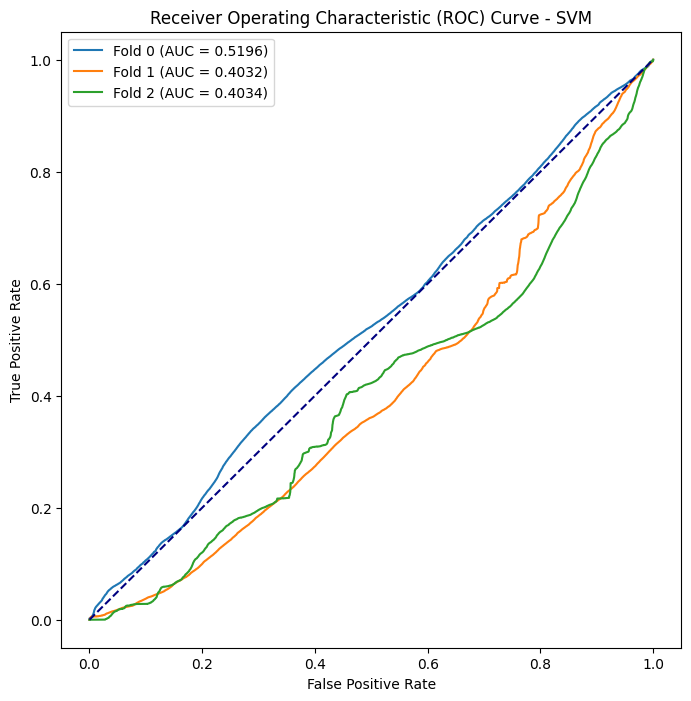

In [33]:
# roc curve

plt.figure(figsize=(8, 8))

for fold in range(n_splits):
    y_prob = svm_models[fold].decision_function(X_test[fold])
    fpr, tpr, _ = roc_curve(y_test[fold], y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC) Curve - SVM')
plt.legend()

plt.show()

In [34]:
# plot confusion matrix

for fold in range(n_splits):
    y_pred = svm_models[fold].predict(X_test[fold])

    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test[fold], y_pred), index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion_matrix_df)
    print(classification_report(y_test[fold], y_pred))


Fold 0 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal             354505             837595
Actual Anomaly             16480              41420
              precision    recall  f1-score   support

         0.0       0.96      0.30      0.45   1192100
         1.0       0.05      0.72      0.09     57900

    accuracy                           0.32   1250000
   macro avg       0.50      0.51      0.27   1250000
weighted avg       0.91      0.32      0.44   1250000

Fold 1 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal             749123             446577
Actual Anomaly             40753              13547
              precision    recall  f1-score   support

         0.0       0.95      0.63      0.75   1195700
         1.0       0.03      0.25      0.05     54300

    accuracy                           0.61   1250000
   macro avg       0.49      0.44      0.40   1250000
weighted avg       0.91      0.61      

#### Random Forest

In [15]:
# train random forest classifier

from sklearn.ensemble import RandomForestClassifier

def train_random_forest(X_train, y_train, n_estimators=100, max_depth=None, random_state=42):
    """
    Train a Random Forest Classifier.

    Parameters:
    X_train (DataFrame): Training feature set.
    y_train (Series): Training labels.
    n_estimators (int): Number of trees in the forest. Default is 100.
    max_depth (int): Maximum depth of the tree. Default is None.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    RandomForestClassifier: The trained Random Forest Classifier model.
    """
    # Create a Random Forest Classifier instance
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=random_state, verbose=1)
    
    # Fit the model on the training data
    clf.fit(X_train, y_train)
    
    return clf

In [16]:
# Train a Random Forest Classifier model for each fold

random_forest_models = {}

for fold in range(n_splits):
    random_forest_models[fold] = train_random_forest(X_train[fold], y_train[fold])
    print(f"Fold {fold} Random Forest model trained")

Fold 0 Random Forest model trained
Fold 1 Random Forest model trained
Fold 2 Random Forest model trained


In [17]:
def evaluate_random_forest(model, X_test, y_test):
    """
    Evaluate the performance of a Random Forest Classifier model.

    Parameters:
    model (RandomForestClassifier): Trained Random Forest Classifier model.
    X_test (DataFrame): Test feature set.
    y_test (Series): True labels for the test set.

    Returns:
    dict: A dictionary containing the evaluation metrics.
    """
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    return metrics

In [18]:
# evaluate the models for each fold

random_forest_metrics = {}

for fold in range(n_splits):
    random_forest_metrics[fold] = evaluate_random_forest(random_forest_models[fold], X_test[fold], y_test[fold])
    print(f"Fold {fold} Random Forest model evaluated")

# Display the evaluation metrics for each fold

random_forest_metrics_df = pd.DataFrame(random_forest_metrics).T

random_forest_metrics_df

Fold 0 Random Forest model evaluated
Fold 1 Random Forest model evaluated
Fold 2 Random Forest model evaluated


,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.950598,0.036788,0.002642,0.004931,0.676034
1,0.957468,0.741181,0.032118,0.061568,0.648477
2,0.964373,0.913958,0.269253,0.415963,0.732624


In [19]:
# take average of evaluation metrics

random_forest_metrics_avg = random_forest_metrics_df.mean()

random_forest_metrics_avg

Accuracy     0.957479
Precision    0.563976
Recall       0.101338
F1 Score     0.160820
ROC AUC      0.685712
dtype: float64

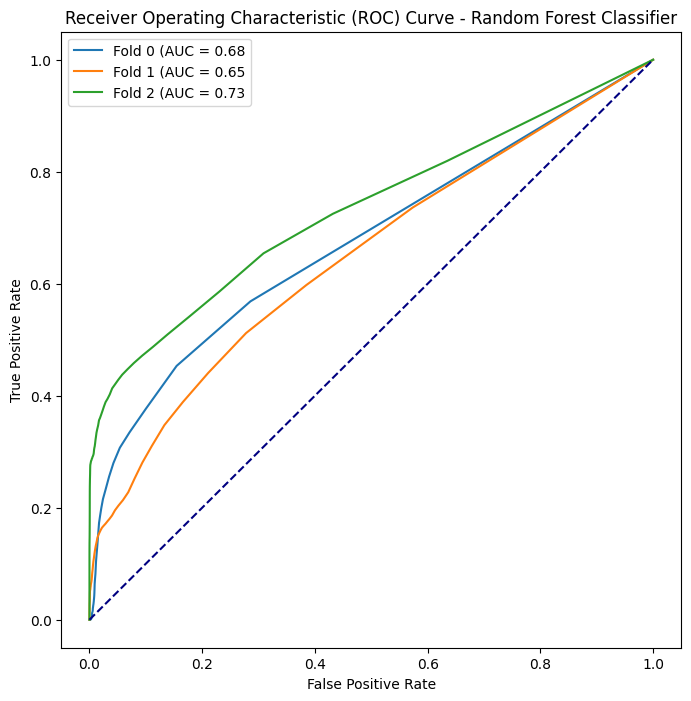

In [20]:
# roc curve

plt.figure(figsize=(8, 8))

for fold in range(n_splits):
    y_prob = random_forest_models[fold].predict_proba(X_test[fold])[:, 1]
    fpr, tpr, _ = roc_curve(y_test[fold], y_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.2f}")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Random Forest Classifier')
plt.legend()
plt.show()

In [50]:
# plot confusion matrix

for fold in range(n_splits):
    y_pred = random_forest_models[fold].predict(X_test[fold])
    
    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test[fold], y_pred), index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion_matrix_df)
    print(classification_report(y_test[fold], y_pred))

Fold 0 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1188094               4006
Actual Anomaly             57747                153
              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97   1192100
         1.0       0.04      0.00      0.00     57900

    accuracy                           0.95   1250000
   macro avg       0.50      0.50      0.49   1250000
weighted avg       0.91      0.95      0.93   1250000

Fold 1 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1195091                609
Actual Anomaly             52556               1744
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98   1195700
         1.0       0.74      0.03      0.06     54300

    accuracy                           0.96   1250000
   macro avg       0.85      0.52      0.52   1250000
weighted avg       0.95      0.96      

## Deep Learning Models

### Recurrent Neural Networks

In [ ]:
def train_rnn(X_train, y_train, n_units=64, n_epochs=10, batch_size=32, random_state=42):

    """
    Train a Recurrent Neural Network (RNN) model.

    Parameters:
    X_train (DataFrame): Training feature set.
    y_train (Series): Training labels.
    n_units (int): Number of units in the RNN layer. Default is 64.
    n_epochs (int): Number of epochs for training. Default is 10.
    batch_size (int): Number of samples per gradient update. Default is 32.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    Sequential: The trained RNN model.
    """

    # Reshape the input data
    X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])

    # Create validation set from the last 10% of the training data
    n_train = int(X_train_reshaped.shape[0] * 0.9)
    X_train_split, X_val = X_train_reshaped[:n_train], X_train_reshaped[n_train:]
    y_train_split, y_val = y_train[:n_train], y_train[n_train:]

    # Create an RNN model
    model = Sequential()
    model.add(SimpleRNN(n_units, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
        baseline=None, restore_best_weights=True
    )

    # Fit the model
    history = model.fit(X_train_split, y_train_split, epochs=n_epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

    return history, model

In [ ]:
# Train an RNN model for each fold

rnn_models = {}
rnn_histories = {}

for fold in range(n_splits):
    rnn_histories[fold], rnn_models[fold] = train_rnn(X_train[fold], y_train[fold])
    print(f"Fold {fold} RNN model trained")

Epoch 1/10
69244/69244 [==============================] - 247s 4ms/step - loss: 0.0430 - accuracy: 0.9866 - val_loss: 0.0113 - val_accuracy: 0.9965
Epoch 2/10
69244/69244 [==============================] - 245s 4ms/step - loss: 0.0045 - accuracy: 0.9990 - val_loss: 0.0087 - val_accuracy: 0.9981
Epoch 3/10
69244/69244 [==============================] - 240s 3ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0043 - val_accuracy: 0.9994
Epoch 4/10
69244/69244 [==============================] - 241s 3ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 7.5239e-04 - val_accuracy: 1.0000
Epoch 5/10
69244/69244 [==============================] - 242s 3ms/step - loss: 0.0014 - accuracy: 0.9997 - val_loss: 0.0026 - val_accuracy: 0.9992
Epoch 6/10
69244/69244 [==============================] - 240s 3ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 0.0015 - val_accuracy: 0.9995
Epoch 7/10
69244/69244 [==============================] - 241s 3ms/step - loss: 0.0010 - accuracy: 0.9997 - 

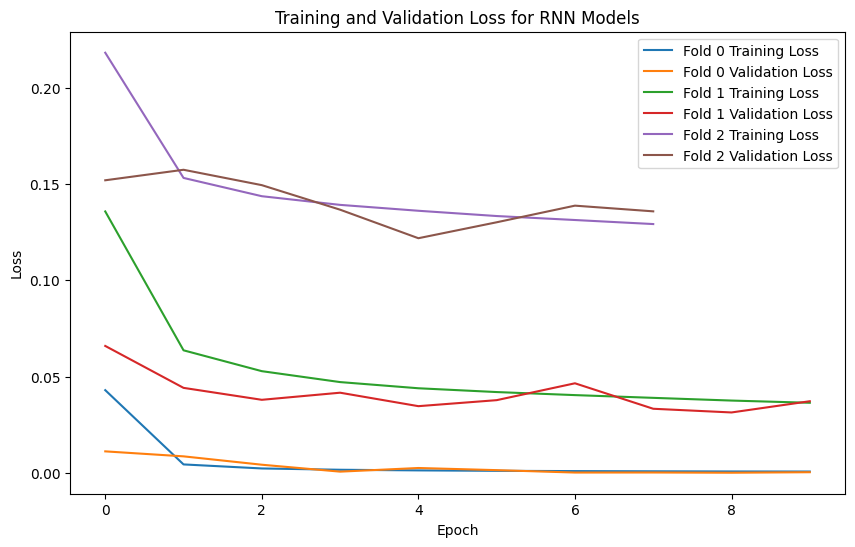

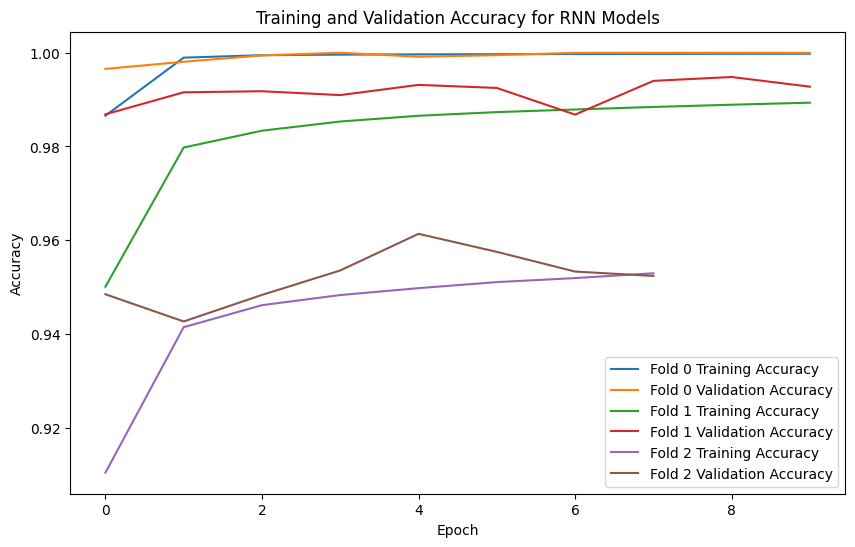

In [ ]:
# plot training and validation loss

plt.figure(figsize=(10, 6))

for fold in range(n_splits):
    history = rnn_histories[fold]
    plt.plot(history.history['loss'], label=f"Fold {fold} Training Loss")
    plt.plot(history.history['val_loss'], label=f"Fold {fold} Validation Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for RNN Models')
plt.legend()
plt.show()

# plot training and validation accuracy

plt.figure(figsize=(10, 6))

for fold in range(n_splits):
    history = rnn_histories[fold]
    plt.plot(history.history['accuracy'], label=f"Fold {fold} Training Accuracy")
    plt.plot(history.history['val_accuracy'], label=f"Fold {fold} Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for RNN Models')
plt.legend()
plt.show()

In [ ]:
def evaluate_NN(model, X_test, y_test):
    """
    Evaluate the performance of an RNN model.

    Parameters:
    model (Sequential): Trained RNN model.
    X_test (DataFrame): Test feature set.
    y_test (Series): True labels for the test set.

    Returns:
    dict: A dictionary containing the evaluation metrics.
    """
    # Reshape the input data
    X_test_reshaped = X_test.values.reshape(X_test.shape[0], 1, X_test.shape[1])

    # Make predictions
    y_prob = model.predict(X_test_reshaped)
    y_pred = (y_prob > 0.5).astype(int)

    # Compute evaluation metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_prob)

    metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'ROC AUC': roc_auc
    }

    return metrics

In [ ]:
# evaluate the models for each fold

rnn_metrics = {}

for fold in range(n_splits):
    rnn_metrics[fold] = evaluate_NN(rnn_models[fold], X_test[fold], y_test[fold])
    print(f"Fold {fold} RNN model evaluated")

# Display the evaluation metrics for each fold

rnn_metrics_df = pd.DataFrame(rnn_metrics).T

rnn_metrics_df

39063/39063 [==============================] - 54s 1ms/step
Fold 0 RNN model evaluated
39063/39063 [==============================] - 54s 1ms/step
Fold 1 RNN model evaluated
39063/39063 [==============================] - 54s 1ms/step
Fold 2 RNN model evaluated


,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.948798,0.359634,0.135009,0.196318,0.625264
1,0.921104,0.208114,0.290976,0.242666,0.635761
2,0.906772,0.232037,0.423667,0.299850,0.712031


In [ ]:
# take average of evaluation metrics

rnn_metrics_avg = rnn_metrics_df.mean()

rnn_metrics_avg

Accuracy     0.925558
Precision    0.266595
Recall       0.283217
F1 Score     0.246278
ROC AUC      0.657685
dtype: float64

39063/39063 [==============================] - 55s 1ms/step


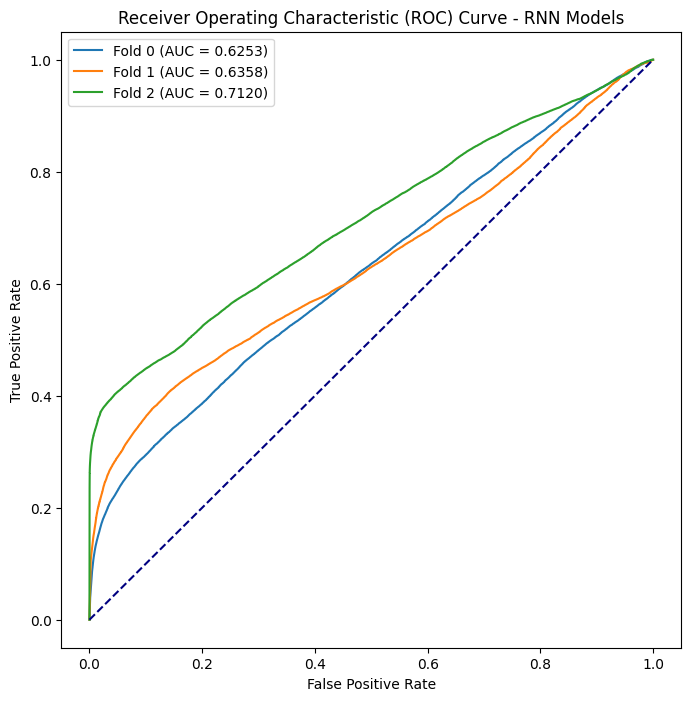

In [ ]:
# roc curve

plt.figure(figsize=(8, 8))

for fold in range(n_splits):
    X_test_reshaped = X_test[fold].values.reshape(X_test[fold].shape[0], 1, X_test[fold].shape[1])
    y_prob = rnn_models[fold].predict(X_test_reshaped)
    fpr, tpr, _ = roc_curve(y_test[fold], y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - RNN Models')
plt.legend()
plt.show()

In [ ]:
# plot confusion matrix

for fold in range(n_splits):
    X_test_reshaped = X_test[fold].values.reshape(X_test[fold].shape[0], 1, X_test[fold].shape[1])
    y_prob = rnn_models[fold].predict(X_test_reshaped)
    y_pred = (y_prob > 0.5).astype(int)

    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test[fold], y_pred), index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion_matrix_df)
    print(classification_report(y_test[fold], y_pred))

39063/39063 [==============================] - 55s 1ms/step
Fold 0 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1178181              13919
Actual Anomaly             50083               7817
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97   1192100
         1.0       0.36      0.14      0.20     57900

    accuracy                           0.95   1250000
   macro avg       0.66      0.56      0.58   1250000
weighted avg       0.93      0.95      0.94   1250000

39063/39063 [==============================] - 55s 1ms/step
Fold 1 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1135580              60120
Actual Anomaly             38500              15800
              precision    recall  f1-score   support

         0.0       0.97      0.95      0.96   1195700
         1.0       0.21      0.29      0.24     54300

    accuracy               

### LSTMs

In [ ]:
# train LSTM

from tensorflow.keras.layers import LSTM

def train_lstm(X_train, y_train, n_units=64, n_epochs=10, batch_size=32, random_state=42):

    """
    Train a Long Short-Term Memory (LSTM) model.

    Parameters:
    X_train (DataFrame): Training feature set.
    y_train (Series): Training labels.
    n_units (int): Number of units in the LSTM layer. Default is 64.
    n_epochs (int): Number of epochs for training. Default is 10.
    batch_size (int): Number of samples per gradient update. Default is 32.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    Sequential: The trained LSTM model.
    """

    # Reshape the input data
    X_train_reshaped = X_train.values.reshape(X_train.shape[0], 1, X_train.shape[1])

    # Create validation set from the last 10% of the training data
    n_train = int(X_train_reshaped.shape[0] * 0.9)
    X_train_split, X_val = X_train_reshaped[:n_train], X_train_reshaped[n_train:]
    y_train_split, y_val = y_train[:n_train], y_train[n_train:]

    # Create an LSTM model
    model = Sequential()
    model.add(LSTM(n_units, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2])))
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
        baseline=None, restore_best_weights=True
    )

    # Fit the model
    history = model.fit(X_train_split, y_train_split, epochs=n_epochs, batch_size=batch_size, verbose=1, validation_data=(X_val, y_val), callbacks=[early_stopping])

    return history, model

In [ ]:
# Train an LSTM model for each fold

lstm_models = {}
lstm_histories = {}

for fold in range(n_splits):
    lstm_histories[fold], lstm_models[fold] = train_lstm(X_train[fold], y_train[fold])
    print(f"Fold {fold} LSTM model trained")

Epoch 1/10
69244/69244 [==============================] - 238s 3ms/step - loss: 0.0258 - accuracy: 0.9918 - val_loss: 0.0021 - val_accuracy: 0.9999
Epoch 2/10
69244/69244 [==============================] - 235s 3ms/step - loss: 0.0020 - accuracy: 0.9995 - val_loss: 0.0023 - val_accuracy: 0.9993
Epoch 3/10
69244/69244 [==============================] - 239s 3ms/step - loss: 0.0012 - accuracy: 0.9997 - val_loss: 6.9050e-04 - val_accuracy: 0.9998
Epoch 4/10
69244/69244 [==============================] - 234s 3ms/step - loss: 9.4521e-04 - accuracy: 0.9997 - val_loss: 2.4828e-04 - val_accuracy: 1.0000
Epoch 5/10
69244/69244 [==============================] - 231s 3ms/step - loss: 8.0751e-04 - accuracy: 0.9998 - val_loss: 9.7583e-05 - val_accuracy: 1.0000
Epoch 6/10
69244/69244 [==============================] - 229s 3ms/step - loss: 6.9989e-04 - accuracy: 0.9998 - val_loss: 1.4448e-04 - val_accuracy: 1.0000
Epoch 7/10
69244/69244 [==============================] - 232s 3ms/step - loss: 6.39

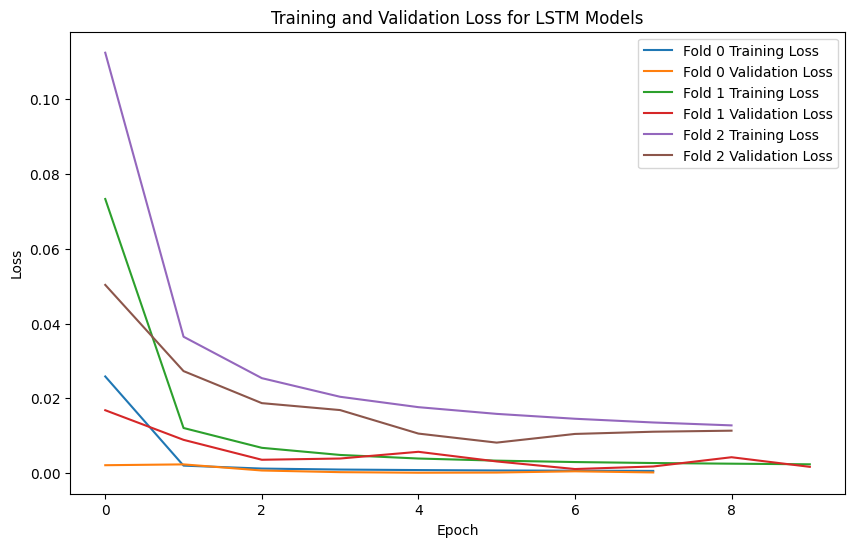

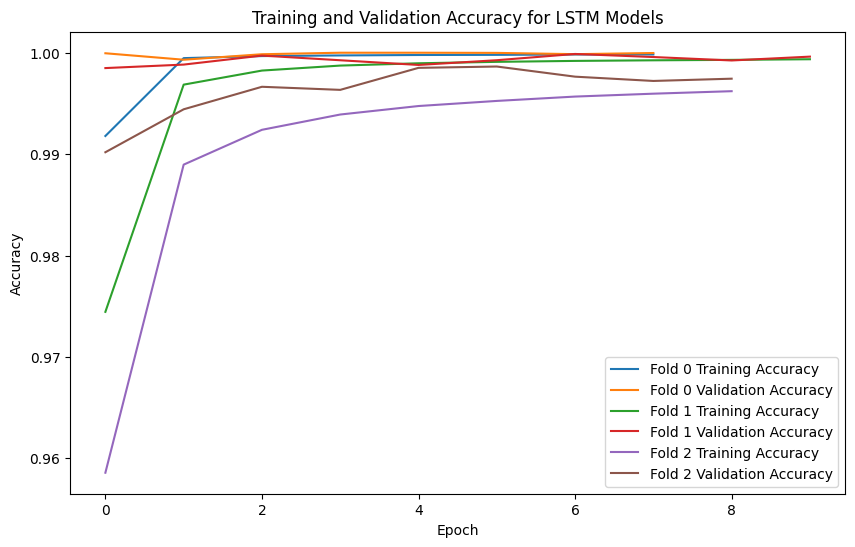

In [ ]:
# plot training and validation loss

plt.figure(figsize=(10, 6))

for fold in range(n_splits):
    history = lstm_histories[fold]
    plt.plot(history.history['loss'], label=f"Fold {fold} Training Loss")
    plt.plot(history.history['val_loss'], label=f"Fold {fold} Validation Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for LSTM Models')
plt.legend()
plt.show()

# plot training and validation accuracy

plt.figure(figsize=(10, 6))

for fold in range(n_splits):
    history = lstm_histories[fold]
    plt.plot(history.history['accuracy'], label=f"Fold {fold} Training Accuracy")
    plt.plot(history.history['val_accuracy'], label=f"Fold {fold} Validation Accuracy")

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy for LSTM Models')
plt.legend()
plt.show()

In [ ]:
# evaluate the models for each fold

lstm_metrics = {}

for fold in range(n_splits):
    lstm_metrics[fold] = evaluate_NN(lstm_models[fold], X_test[fold], y_test[fold])
    print(f"Fold {fold} LSTM model evaluated")

# Display the evaluation metrics for each fold

lstm_metrics_df = pd.DataFrame(lstm_metrics).T

lstm_metrics_df

39063/39063 [==============================] - 62s 2ms/step
Fold 0 LSTM model evaluated
39063/39063 [==============================] - 60s 2ms/step
Fold 1 LSTM model evaluated
39063/39063 [==============================] - 61s 2ms/step
Fold 2 LSTM model evaluated


,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,0.946776,0.282948,0.097150,0.144639,0.558013
1,0.914998,0.129632,0.167440,0.146130,0.621710
2,0.931406,0.293379,0.323548,0.307726,0.699333


In [ ]:
# take average of evaluation metrics

lstm_metrics_avg = lstm_metrics_df.mean()

lstm_metrics_avg

Accuracy     0.931060
Precision    0.235319
Recall       0.196046
F1 Score     0.199498
ROC AUC      0.626352
dtype: float64

39063/39063 [==============================] - 62s 2ms/step


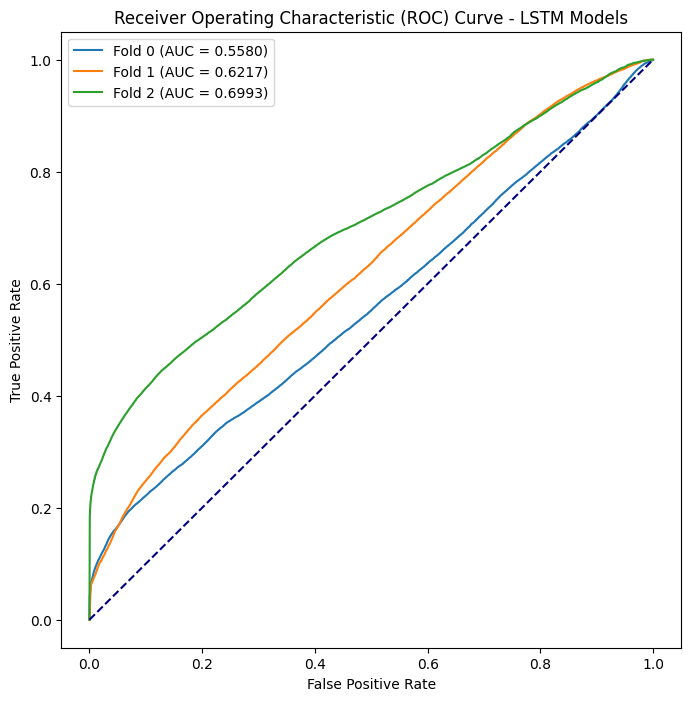

In [ ]:
# roc curve

plt.figure(figsize=(8, 8))

for fold in range(n_splits):
    X_test_reshaped = X_test[fold].values.reshape(X_test[fold].shape[0], 1, X_test[fold].shape[1])
    y_prob = lstm_models[fold].predict(X_test_reshaped)
    fpr, tpr, _ = roc_curve(y_test[fold], y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - LSTM Models')
plt.legend()
plt.show()

In [ ]:
# plot confusion matrix

for fold in range(n_splits):
    X_test_reshaped = X_test[fold].values.reshape(X_test[fold].shape[0], 1, X_test[fold].shape[1])
    y_prob = lstm_models[fold].predict(X_test_reshaped)
    y_pred = (y_prob > 0.5).astype(int)

    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test[fold], y_pred), index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion_matrix_df)
    print(classification_report(y_test[fold], y_pred))

39063/39063 [==============================] - 61s 2ms/step
Fold 0 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1177845              14255
Actual Anomaly             52275               5625
              precision    recall  f1-score   support

         0.0       0.96      0.99      0.97   1192100
         1.0       0.28      0.10      0.14     57900

    accuracy                           0.95   1250000
   macro avg       0.62      0.54      0.56   1250000
weighted avg       0.93      0.95      0.93   1250000

39063/39063 [==============================] - 62s 2ms/step
Fold 1 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1134655              61045
Actual Anomaly             45208               9092
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96   1195700
         1.0       0.13      0.17      0.15     54300

    accuracy               

### Autoencoder

In [ ]:
# autoencoder

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Flatten, Reshape, BatchNormalization, Activation
import keras
from keras import layers

def train_autoencoder(X_train, n_epochs=10, batch_size=64, random_state=42):
    """
    Train an Autoencoder model for anomaly detection.

    Parameters:
    X_train (DataFrame): Training feature set.
    n_epochs (int): Number of epochs for training. Default is 10.
    batch_size (int): Number of samples per gradient update. Default is 256.
    random_state (int): Random state for reproducibility. Default is 42.

    Returns:
    history (History): The training history of the model.
    autoencoder (Model): The trained Autoencoder model.
    """

    # Reshape data for LSTM input (assuming time series data)
    X_train_reshaped = X_train.values.reshape(X_train.shape[0], X_train.shape[1], 1)  # Add extra dimension for timestep

    input_shape = (X_train_reshaped.shape[1], X_train_reshaped.shape[2])

    # Build LSTM autoencoder model
    model = keras.Sequential([
        keras.layers.Input(shape=input_shape),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.LSTM(16, return_sequences=False),
        keras.layers.RepeatVector(input_shape[0]),  # Repeat the vector to match input shape
        keras.layers.LSTM(16, return_sequences=True),
        keras.layers.LSTM(32, return_sequences=True),
        keras.layers.TimeDistributed(keras.layers.Dense(input_shape[1]))  # Time distributed dense layer
    ])

    model.compile(optimizer='adam', loss='mse')

    # Early stopping
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=3, verbose=0, mode='auto',
        baseline=None, restore_best_weights=True
    )

    n_train = int(X_train_reshaped.shape[0] * 0.9)
    X_train_split, X_val = X_train_reshaped[:n_train], X_train_reshaped[n_train:]

    # Fit the model
    history = model.fit(X_train_split, X_train_split, epochs=n_epochs, batch_size=batch_size, validation_data = (X_val, X_val) , shuffle = False, verbose = 1, callbacks = [early_stopping])

    return history, model

In [ ]:
# Train an Autoencoder model for each fold

autoencoder_models = {}
autoencoder_histories = {}

for fold in range(n_splits):
    autoencoder_histories[fold], autoencoder_models[fold] = train_autoencoder(X_train[fold])
    print(f"Fold {fold} Autoencoder model trained")

Epoch 1/10
34622/34622 [==============================] - 294s 8ms/step - loss: 1.1185 - val_loss: 0.2322
Epoch 2/10
34622/34622 [==============================] - 278s 8ms/step - loss: 0.5434 - val_loss: 0.1400
Epoch 3/10
34622/34622 [==============================] - 280s 8ms/step - loss: 0.2747 - val_loss: 0.0563
Epoch 4/10
34622/34622 [==============================] - 282s 8ms/step - loss: 0.1434 - val_loss: 0.0318
Epoch 5/10
34622/34622 [==============================] - 282s 8ms/step - loss: 0.1446 - val_loss: 0.0141
Epoch 6/10
34622/34622 [==============================] - 287s 8ms/step - loss: 0.0907 - val_loss: 0.0111
Epoch 7/10
34622/34622 [==============================] - 285s 8ms/step - loss: 0.0723 - val_loss: 0.0067
Epoch 8/10
34622/34622 [==============================] - 281s 8ms/step - loss: 0.0652 - val_loss: 0.0058
Epoch 9/10
34622/34622 [==============================] - 280s 8ms/step - loss: 0.0563 - val_loss: 0.0048
Epoch 10/10
34622/34622 [=====================

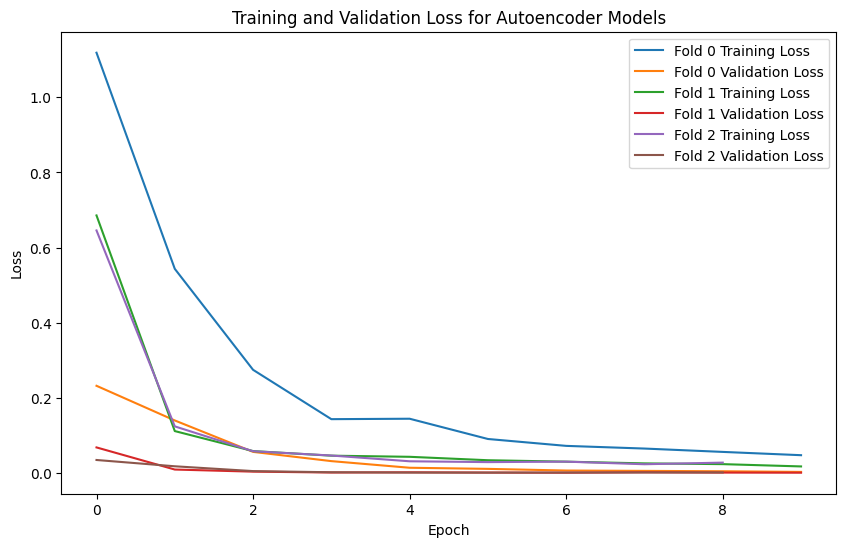

In [ ]:
# plot training and validation loss

plt.figure(figsize=(10, 6))

for fold in range(n_splits):
    history = autoencoder_histories[fold]
    plt.plot(history.history['loss'], label=f"Fold {fold} Training Loss")
    plt.plot(history.history['val_loss'], label=f"Fold {fold} Validation Loss")

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss for Autoencoder Models')
plt.legend()
plt.show()

In [ ]:
def evaluate_autoencoder(model, X_test, y_test, threshold=None):
    """
    Evaluate the LSTM autoencoder model.

    Parameters:
    model (Model): The trained LSTM autoencoder model.
    X_test (ndarray): Test feature set.
    y_test (array-like): True labels for the test set.
    threshold (float): Reconstruction error threshold for classifying anomalies.

    Returns:
    dict: A dictionary containing evaluation metrics.
    """

    # Reshape data for LSTM autoencoder input
    X_test = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Get the reconstruction errors
    X_test_pred = model.predict(X_test)
    reconstruction_errors = np.mean(np.abs(X_test_pred - X_test), axis=1)

    # Determine the threshold if not provided
    if threshold is None:
        threshold = np.percentile(reconstruction_errors, 95)  # Adjust the percentile as needed

    # Classify as anomaly or not
    y_pred = (reconstruction_errors > threshold).astype(int)

    # Calculate metrics
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, reconstruction_errors)
    accuracy = accuracy_score(y_test, y_pred)

    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'roc_auc_score': roc_auc,
    }

    return metrics

In [ ]:
# evaluate the models for each fold

autoencoder_metrics = {}

for fold in range(n_splits):
    autoencoder_metrics[fold] = evaluate_autoencoder(autoencoder_models[fold], X_test[fold], y_test[fold])
    print(f"Fold {fold} Autoencoder model evaluated")

# Display the evaluation metrics for each fold

autoencoder_metrics_df = pd.DataFrame(autoencoder_metrics).T

autoencoder_metrics_df

39063/39063 [==============================] - 144s 4ms/step
Fold 0 Autoencoder model evaluated
39063/39063 [==============================] - 144s 4ms/step
Fold 1 Autoencoder model evaluated
39063/39063 [==============================] - 142s 4ms/step
Fold 2 Autoencoder model evaluated


,accuracy,precision,recall,f1_score,roc_auc_score
0,0.918315,0.146352,0.157979,0.151944,0.630676
1,0.914782,0.082224,0.094641,0.087997,0.618398
2,0.912309,0.094288,0.100051,0.097084,0.669355


In [ ]:
# take average of evaluation metrics

autoencoder_metrics_avg = autoencoder_metrics_df.mean()

autoencoder_metrics_avg

accuracy         0.915135
precision        0.107621
recall           0.117557
f1_score         0.112341
roc_auc_score    0.639477
dtype: float64

39063/39063 [==============================] - 143s 4ms/step


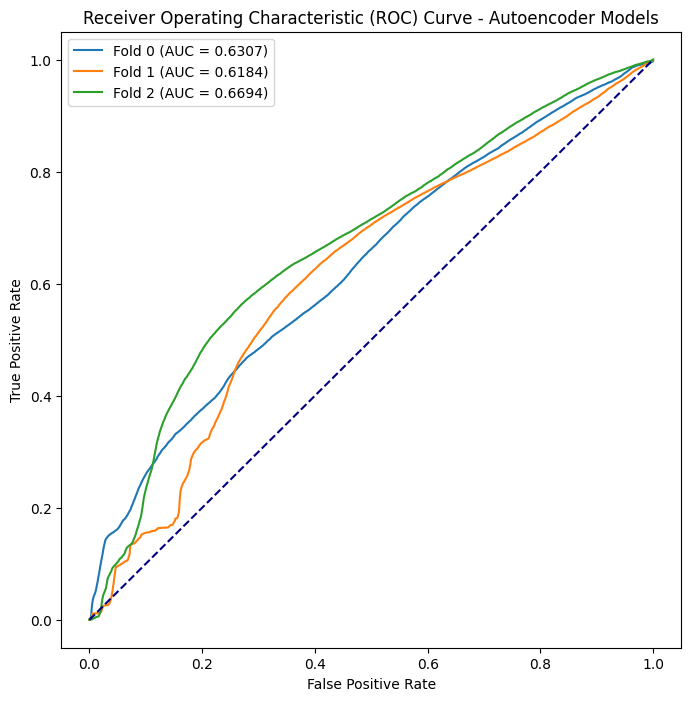

In [ ]:
# roc curve

plt.figure(figsize=(8, 8))

for fold in range(n_splits):
    X_test_reshaped = X_test[fold].values.reshape((X_test[fold].shape[0], X_test[fold].shape[1], 1))
    X_pred = autoencoder_models[fold].predict(X_test[fold])
    mae = np.mean(np.abs(X_test_reshaped - X_pred), axis=1)
    fpr, tpr, _ = roc_curve(y_test[fold], mae)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"Fold {fold} (AUC = {roc_auc:.4f})")

plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Autoencoder Models')
plt.legend()
plt.show()

In [ ]:
# plot confusion matrix

for fold in range(n_splits):
    X_test_reshaped = X_test[fold].values.reshape((X_test[fold].shape[0], X_test[fold].shape[1], 1))
    X_pred = autoencoder_models[fold].predict(X_test[fold])
    mae = np.mean(np.abs(X_test_reshaped - X_pred), axis=1)
    threshold = np.percentile(mae, 95)
    y_pred_binary = (mae > threshold).astype(int)

    confusion_matrix_df = pd.DataFrame(confusion_matrix(y_test[fold], y_pred_binary), index=['Actual Normal', 'Actual Anomaly'], columns=['Predicted Normal', 'Predicted Anomaly'])
    print(f"Fold {fold} Confusion Matrix:")
    print(confusion_matrix_df)
    print(classification_report(y_test[fold], y_pred_binary))

39063/39063 [==============================] - 146s 4ms/step
Fold 0 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1138747              53353
Actual Anomaly             48753               9147
              precision    recall  f1-score   support

         0.0       0.96      0.96      0.96   1192100
         1.0       0.15      0.16      0.15     57900

    accuracy                           0.92   1250000
   macro avg       0.55      0.56      0.55   1250000
weighted avg       0.92      0.92      0.92   1250000

39063/39063 [==============================] - 146s 4ms/step
Fold 1 Confusion Matrix:
                Predicted Normal  Predicted Anomaly
Actual Normal            1138339              57361
Actual Anomaly             49161               5139
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96   1195700
         1.0       0.08      0.09      0.09     54300

    accuracy             

In [ ]:
# read data

df = pd.read_csv('avg_performance.csv')

df

,Model,Accuracy,Precision,Recall,F1 Score,ROC AUC
0,Isolation_Forests,0.901937,0.142814,0.208338,0.165582,0.662047
1,Gaussian_Mixture_Models,0.940868,0.364944,0.399081,0.381137,0.769052
2,Support_Vector_Machine,0.589538,0.030962,0.334884,0.054745,0.442065
3,Random_Forests,0.957479,0.563976,0.101338,0.160820,0.685712
4,RNN,0.925558,0.266595,0.283217,0.246278,0.657685
5,LSTM,0.931060,0.235319,0.196046,0.199498,0.626352
6,Autoencoder,0.915135,0.107621,0.117557,0.112341,0.639477


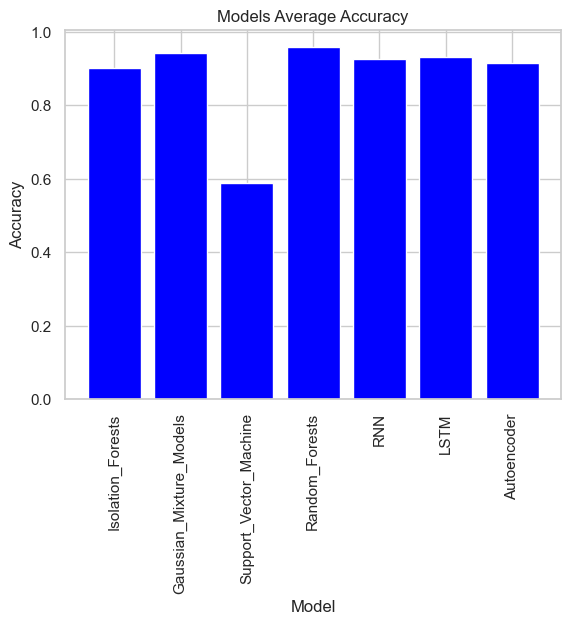

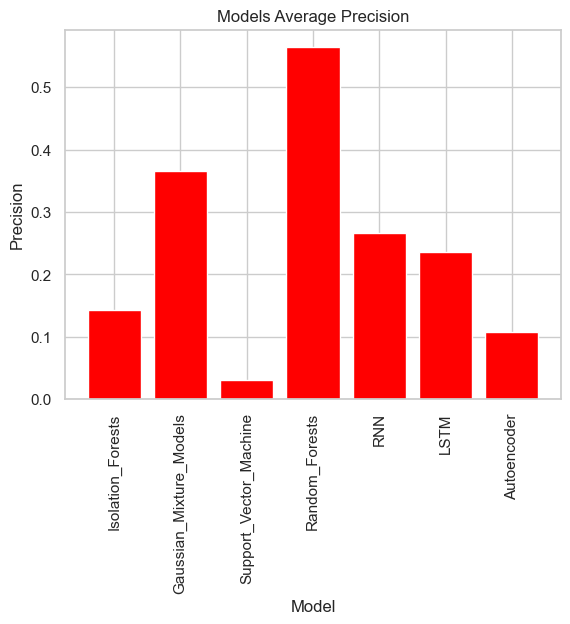

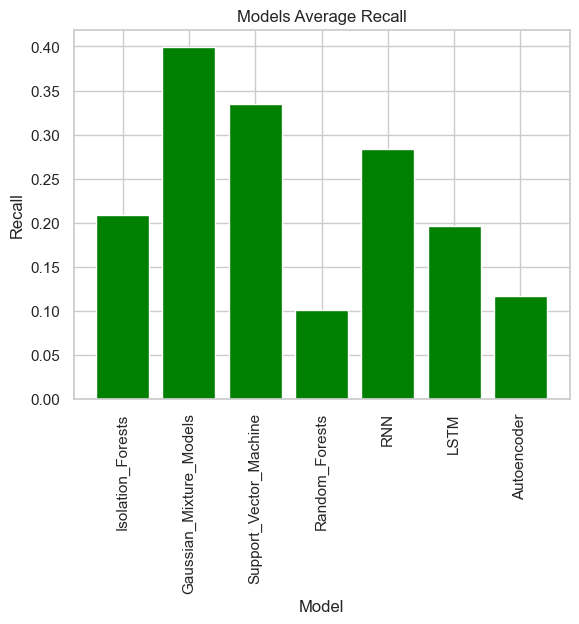

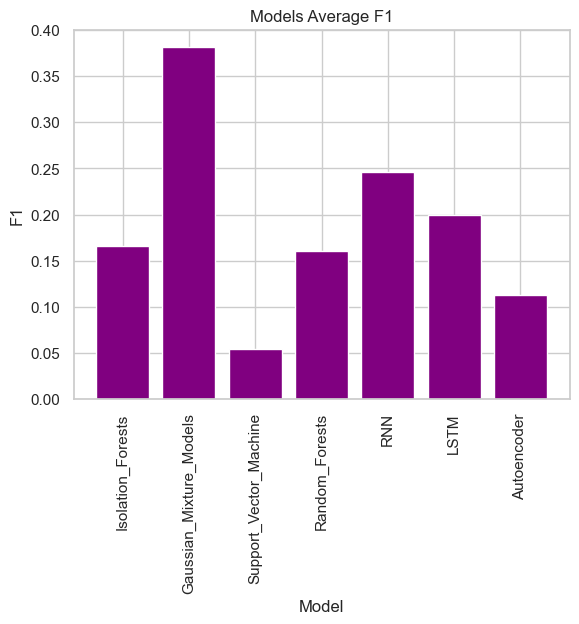

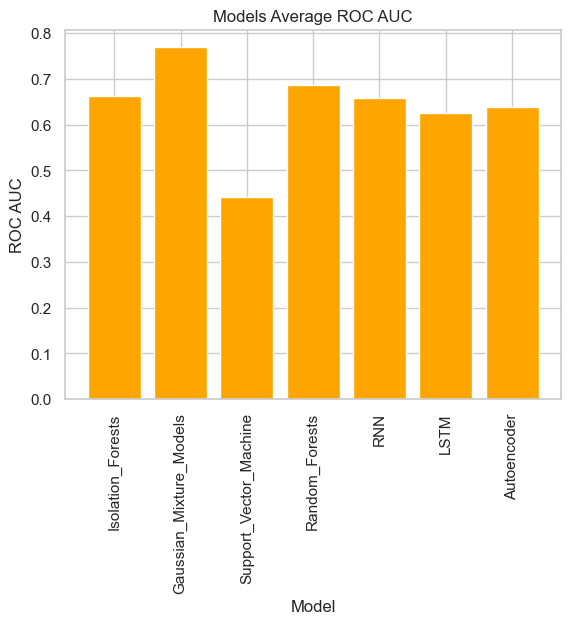

In [ ]:
# accuracy bar chart

plt.bar(df['Model'], df['Accuracy'], color='blue')
plt.title('Models Average Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.show()

# precision bar chart

plt.bar(df['Model'], df['Precision'], color='red')
plt.title('Models Average Precision')
plt.ylabel('Precision')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.show()

# recall bar chart

plt.bar(df['Model'], df['Recall'], color='green')
plt.title('Models Average Recall')
plt.ylabel('Recall')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.show()

# f1 bar chart

plt.bar(df['Model'], df['F1 Score'], color='purple')
plt.title('Models Average F1')
plt.ylabel('F1')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.show()

# ROC AUC bar chart

plt.bar(df['Model'], df['ROC AUC'], color='orange')
plt.title('Models Average ROC AUC')
plt.ylabel('ROC AUC')
plt.xlabel('Model')
plt.xticks(rotation=90)
plt.show()








